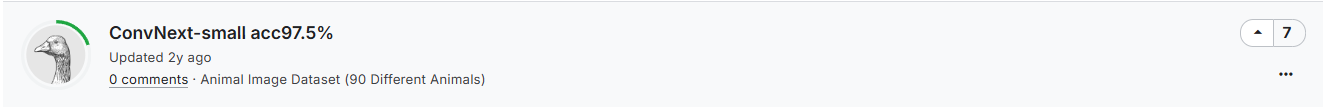

In [1]:
%%writefile my_dataset.py
from PIL import Image
import torch
from torch.utils.data import Dataset


class MyDataSet(Dataset):
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item]).convert('RGB')
        # RGB为彩色图片，L为灰度图片
        
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

Overwriting my_dataset.py


In [2]:
%%writefile utils.py
import os
import sys
import json
import pickle
import random

import torch
from tqdm import tqdm

import matplotlib.pyplot as plt


def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root)

    # 遍历文件夹，一个文件夹对应一个类别
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    # 排序，保证各平台顺序一致
    flower_class.sort()
    # 生成类别名称以及对应的数字索引
    class_indices = dict((k, v) for v, k in enumerate(flower_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 排序，保证各平台顺序一致
        images.sort()
        # 获取该类别对应的索引
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num)))
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))
    assert len(train_images_path) > 0, "number of training images must greater than 0."
    assert len(val_images_path) > 0, "number of validation images must greater than 0."

    plot_image = False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(flower_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(flower_class)), flower_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label


def plot_data_loader_image(data_loader):
    batch_size = data_loader.batch_size
    plot_num = min(batch_size, 4)

    json_path = './class_indices.json'
    assert os.path.exists(json_path), json_path + " does not exist."
    json_file = open(json_path, 'r')
    class_indices = json.load(json_file)

    for data in data_loader:
        images, labels = data
        for i in range(plot_num):
            # [C, H, W] -> [H, W, C]
            img = images[i].numpy().transpose(1, 2, 0)
            # 反Normalize操作
            img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
            label = labels[i].item()
            plt.subplot(1, plot_num, i+1)
            plt.xlabel(class_indices[str(label)])
            plt.xticks([])  # 去掉x轴的刻度
            plt.yticks([])  # 去掉y轴的刻度
            plt.imshow(img.astype('uint8'))
        plt.show()


def write_pickle(list_info: list, file_name: str):
    with open(file_name, 'wb') as f:
        pickle.dump(list_info, f)


def read_pickle(file_name: str) -> list:
    with open(file_name, 'rb') as f:
        info_list = pickle.load(f)
        return info_list


def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    accu_loss = torch.zeros(1).to(device)  # 累计损失
    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    optimizer.zero_grad()

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()
        labels = labels.to(device)
        loss = loss_function(pred, labels)
        loss.backward()
        accu_loss += loss.detach()

        data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num


@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    loss_function = torch.nn.CrossEntropyLoss()

    model.eval()

    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    accu_loss = torch.zeros(1).to(device)  # 累计损失

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num

Overwriting utils.py


In [3]:
import timm
from pprint import pprint
model_names = timm.list_models()
pprint(model_names)

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coa

In [4]:
%%writefile train.py
import os
import argparse

import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

from my_dataset import MyDataSet
#from model import swin_tiny_patch4_window7_224 as create_model
from utils import read_split_data, train_one_epoch, evaluate
import timm


def main(args):
    device = torch.device(args.device if torch.cuda.is_available() else "cpu")

    if os.path.exists("./weights") is False:
        os.makedirs("./weights")

    tb_writer = SummaryWriter()

    train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(args.data_path)

    img_size = 224
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(img_size),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(int(img_size * 1.143)),
                                   transforms.CenterCrop(img_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    # 实例化训练数据集
    train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                              transform=data_transform["train"])

    # 实例化验证数据集
    val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

    batch_size = args.batch_size
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=nw,
                                               collate_fn=train_dataset.collate_fn)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=val_dataset.collate_fn)

    #model = timm.create_model('deit_small_patch16_224', pretrained=True,num_classes=args.num_classes).to(device)
    model = timm.create_model('convnext_small_in22k',pretrained=True,num_classes = args.num_classes).to(device)
    if args.weights != "":
        assert os.path.exists(args.weights), "weights file: '{}' not exist.".format(args.weights)
        weights_dict = torch.load(args.weights, map_location=device)["model"]
        # 删除有关分类类别的权重
        for k in list(weights_dict.keys()):
            if "head" in k:
                del weights_dict[k]
        print(model.load_state_dict(weights_dict, strict=False))

    if args.freeze_layers:
        for name, para in model.named_parameters():
            # 除head外，其他权重全部冻结
            if "head" not in name:
                para.requires_grad_(False)
            else:
                print("training {}".format(name))

    pg = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(pg, lr=args.lr, weight_decay=5E-2)

    for epoch in range(args.epochs):
        # train
        train_loss, train_acc = train_one_epoch(model=model,
                                                optimizer=optimizer,
                                                data_loader=train_loader,
                                                device=device,
                                                epoch=epoch)

        # validate
        val_loss, val_acc = evaluate(model=model,
                                     data_loader=val_loader,
                                     device=device,
                                     epoch=epoch)

        tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[1], train_acc, epoch)
        tb_writer.add_scalar(tags[2], val_loss, epoch)
        tb_writer.add_scalar(tags[3], val_acc, epoch)
        tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

        torch.save(model.state_dict(), "./weights/model-{}.pth".format(epoch))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_classes', type=int, default=5)
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=8)
    parser.add_argument('--lr', type=float, default=0.0001)

    # 数据集所在根目录
    # https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
    parser.add_argument('--data-path', type=str,
                        default="/data/flower_photos")

    # 预训练权重路径，如果不想载入就设置为空字符
    parser.add_argument('--weights', type=str, default='',
                        help='initial weights path')
    # 是否冻结权重
    parser.add_argument('--freeze-layers', type=bool, default=False)
    parser.add_argument('--device', default='cuda:0', help='device id (i.e. 0 or 0,1 or cpu)')

    opt = parser.parse_args()

    main(opt)

Overwriting train.py


In [5]:
!python train.py --data-path D:/code_study/ML_CODE/dataSets/Classification/Animal_Image_Dataset_90DifferentAnimals/animals/animals --num_classes 90 --epochs 20 --batch-size 80

5400 images were found in the dataset.
4320 images for training.
1080 images for validation.
Using 8 dataloader workers every process


c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(
Traceback (most recent call last):
  File "c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\urllib3\connectionpool.py", line 773, in urlopen
    self._prepare_proxy(conn)
  File "c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\urllib3\connectionpool.py", line 1042, in _prepare_proxy
    conn.connect()
  File "c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\urllib3\connection.py", line 713, in connect
    self.sock = sock = self._connect_tls_proxy(self.host, sock)
  File "c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\urllib3\connection.py", line 813, in _connect_tls_proxy
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
  File "c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\urllib3\connection.py", line 920, in _ssl_wrap_socke